<a href="https://colab.research.google.com/github/Binisha1/traffic-light-detection/blob/main/traffic_light_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import urllib.request

In [ ]:
#load images from local devices
def load_from_device(file_path):
  image = cv2.imread(file_path)
  if image is None:
    print(f"[ERROR] Could not load image from file: {file_path}")
  return image


In [ ]:
#download image from given URL and convert it to openCV-readable format
def url_to_image(image):
  try:
    response = urllib.request.urlopen(image)
    image_data = response.read()
    image_array = np.asarray(bytearray(image_data), dtype="uint8")
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    if image is None:
      raise ValueError(f"[ERROR] Could not load image from URL: {image}")
    return image
  except Exception as e:
    print(f"Could not load imaeg from URL: {e}")
    return None

In [ ]:
#resizing the image while keeping its original aspect ratio (resizing ensure consistent scaling for hough circle transform to work reliably)
def resize_image(image, target_height = 600):
  h,w = image.shape[:2]
  aspect_ratio = w/h
  target_width = int(target_height * aspect_ratio)
  resized_image = cv2.resize(image, (target_width, target_height))
  return resized_image

In [ ]:
#show image with title
def show_image_with_title(image,title):
  img_copy = image.copy()
  cv2.putText(img_copy, title, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
  cv2_imshow(img_copy)

In [ ]:
#detect circles in the image using Hough Circle Transform
def detect_circles(image):
  # convert to grayscale and apply gaussian blur as houghcircles relies on edge detection
  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  # show_image_with_title(gray,"grayscale image")
  blurrred = cv2.GaussianBlur(gray,(11,11),0)
  # show_image_with_title(blurrred,"blurred image")

  circles = cv2.HoughCircles(blurrred,cv2.HOUGH_GRADIENT,dp=1.2,minDist=50,param1=100,param2=30,minRadius=10,maxRadius=100)
  if circles is not None:
    return np.round(circles[0, :]).astype("int")
  else:
    return None

In [ ]:
#determine the dominant color within the circle(Red, yellow , green) and return action based on that color
def classify_light_and_action(image,x,y,r):
  mask = np.zeros(image.shape[:2], dtype="uint8")
  cv2.circle(mask, (x, y), r, 255, -1)  # Draw filled circle mask

  #convert image to hsv color space
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Define color ranges(lower and upper boundaries) in HSV
  red_lower1 = np.array([0, 120, 70])
  red_upper1 = np.array([10, 255, 255])
  red_lower2 = np.array([170, 120, 70])
  red_upper2 = np.array([179, 255, 255])
  yellow_lower = np.array([12, 55, 100])
  yellow_upper = np.array([35, 255, 255])
  green_lower = np.array([40, 50, 150])
  green_upper = np.array([90, 255, 255])

  # Create color masks to detect color
  red_mask = cv2.bitwise_or(
      cv2.inRange(hsv_image, red_lower1, red_upper1),
      cv2.inRange(hsv_image, red_lower2, red_upper2)
  )
  yellow_mask = cv2.inRange(hsv_image, yellow_lower, yellow_upper)
  green_mask = cv2.inRange(hsv_image, green_lower, green_upper)

  # Count how many pixels of each color appear inside the circle
  red_pixels = cv2.countNonZero(cv2.bitwise_and(red_mask, red_mask, mask=mask))
  yellow_pixels = cv2.countNonZero(cv2.bitwise_and(yellow_mask, yellow_mask, mask=mask))
  green_pixels = cv2.countNonZero(cv2.bitwise_and(green_mask, green_mask, mask=mask))

  # Return the decision of stop, slowdown or go based on dominant color
  if red_pixels > yellow_pixels and red_pixels > green_pixels:
      return "STOP"
  elif yellow_pixels > red_pixels and yellow_pixels > green_pixels:
      return "SLOW DOWN"
  elif green_pixels > red_pixels and green_pixels > yellow_pixels:
      return "GO"
  else:
      return "UNKNOWN"

In [ ]:
import os
#main function
def classify_traffic_light(image):
  try:
    # Load image from URL or local path
    if image.startswith("http://") or image.startswith("https://"):
      image = url_to_image(image)
    elif os.path.exists(image):
      image = cv2.imread(image)
    else:
      print("[ERROR] Invalid image path or URL.")
      return

    if image is None:
      print("[ERROR] Failed to load image.")
      return

    # show_image_with_title(image,"Original Image") #show original image

    #resize image
    image = resize_image(image,target_height=600)

    #find circles in image using hough circle transform
    circles = detect_circles(image)

    best_circle = None
    max_brightness = -1
    action = "UNKNOWN"

    #loop through circles and find brightest color circle
    if circles is not None:
      for (x, y, r) in circles:
        #create mask and draw white circle in detected circle from hough circle transform
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.circle(mask, (x, y), r, 255, -1)

        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        # extract brightness(v channel) in masked circle
        brightness = cv2.mean(hsv_image[:, :, 2], mask=mask)[0]

        # select brightest circle as best circle
        if brightness > max_brightness:
            max_brightness = brightness
            best_circle = (x, y, r)
            action = classify_light_and_action(image, x, y, r)

      #draw and label brightest circle
      if best_circle:
        x,y,r = best_circle
        cv2.circle(image, (x, y), r, (255, 255, 255),2)

        # color for labeled action in image accorcding to result
        color_map = {
            "STOP": (0, 0, 255),
            "SLOW DOWN": (0, 255, 255),
            "GO": (0, 255, 0),
            "UNKNOWN": (255,255, 255)
        }
        color = color_map.get(action, (255, 255, 255))
        cv2.putText(image,action,(x-r-60, y-r-20),cv2.FONT_HERSHEY_COMPLEX,1.5,color,thickness=4)
      else:
        #no circles found
        cv2.putText(image,"No circles Detected",(20,50,cv2.FONT_HERSHEY_COMPLEX,1.5,(0,0,255),4))

      #final result with action
      cv2_imshow(image)
      print(action)
  except Exception as e:
    print(f"[ERROR] An error has occured during processing {e}")



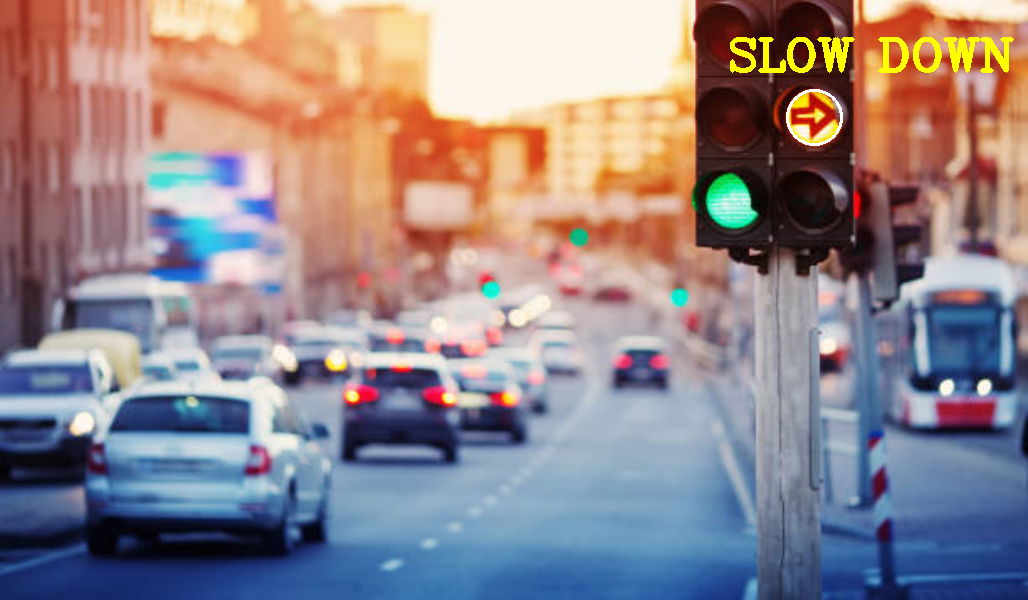

SLOW DOWN


In [ ]:
image = "https://media.istockphoto.com/id/1045979216/photo/cars-moving-on-the-road-in-city-in-late-evening.jpg?s=612x612&w=0&k=20&c=hFfW7WzeeR3X7FTmwkZ0u4_bBzRK1iJcZwisOgdJB3M="
classify_traffic_light(image)

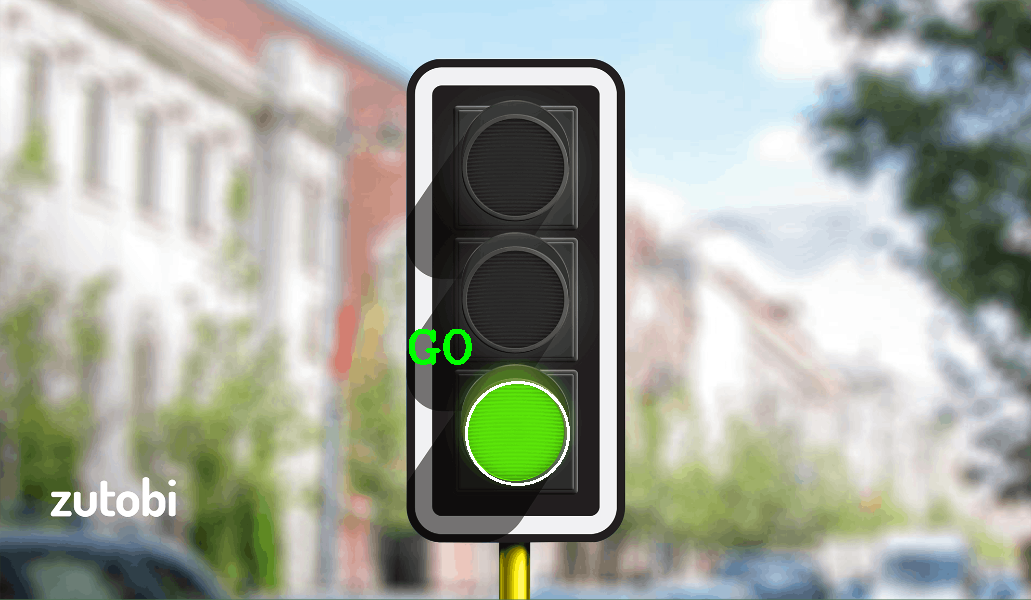

GO


In [ ]:
image = "https://media-blog.zutobi.com/wp-content/uploads/sites/2/2020/11/17095455/Green-Traffic-Light.png?w=2560&auto=format&ixlib=next&fit=max"
classify_traffic_light(image)

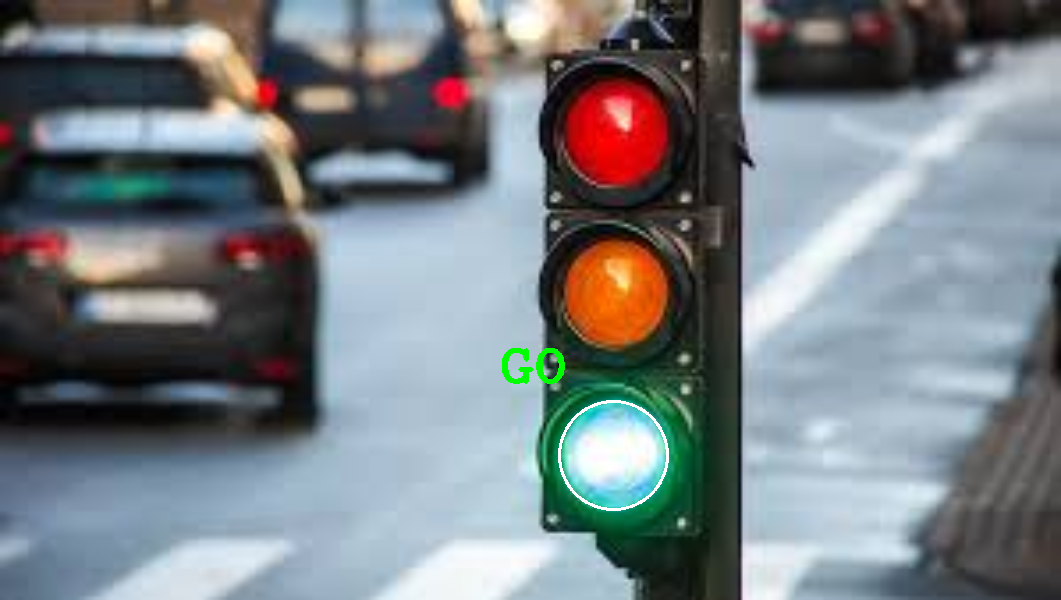

GO


In [ ]:
image = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKysmNbDpBpo59N3iU69T20vC5nC5lFp2jxQ&s"
classify_traffic_light(image)

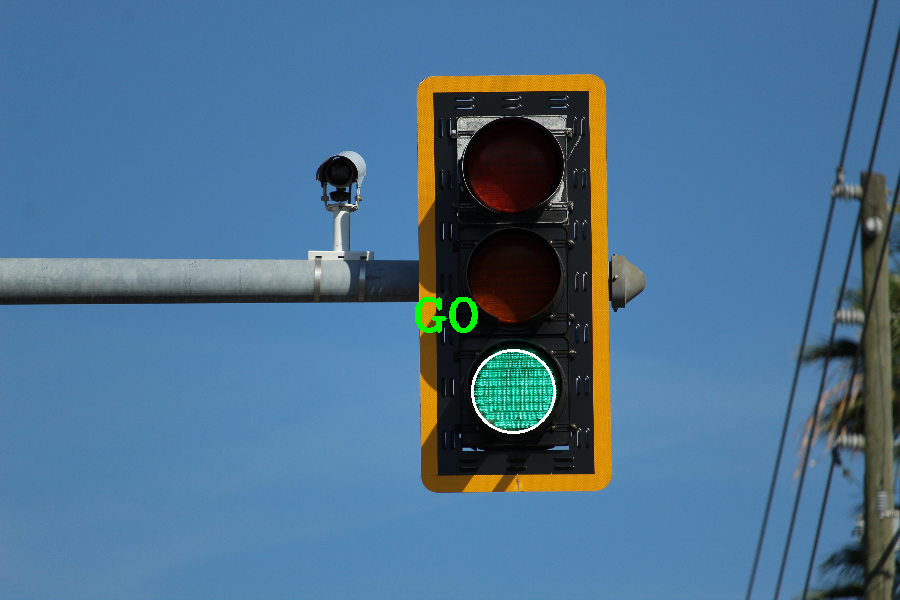

GO


In [ ]:
image ="https://www.roadangelgroup.com/cdn/shop/articles/eliobed-suarez-PN-YnI5stdQ-unsplash_e8ff418d-97fb-4e3c-a78c-8571b6b8e73b.jpg?v=1738581550"
classify_traffic_light(image)

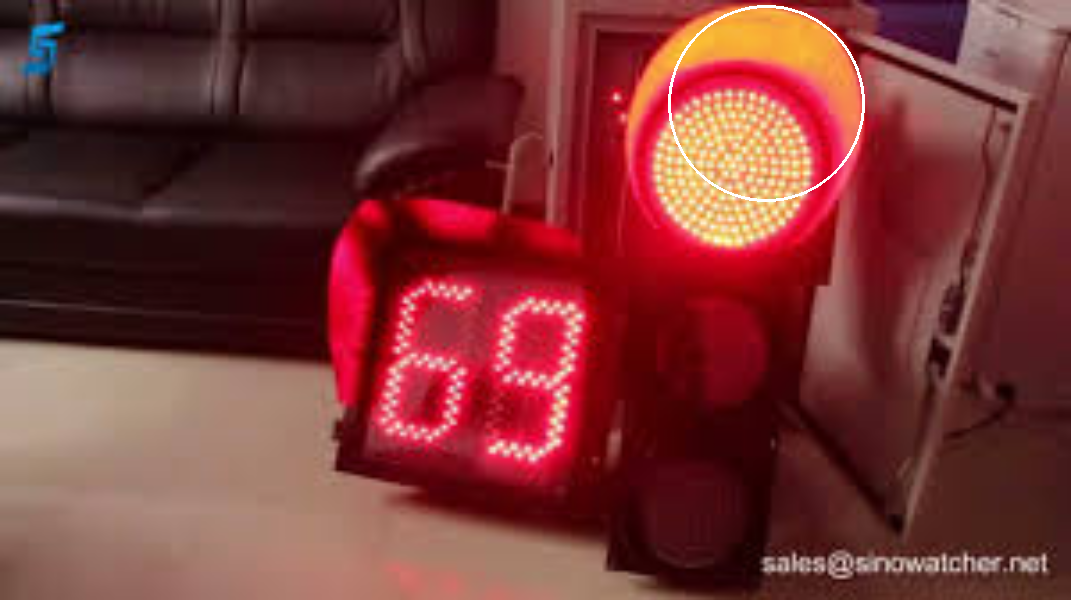

SLOW DOWN


In [ ]:
image = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSBCGR4NLp7T7Eyk97QBpCfsvcH5P8zkv_nYA&s"
classify_traffic_light(image)

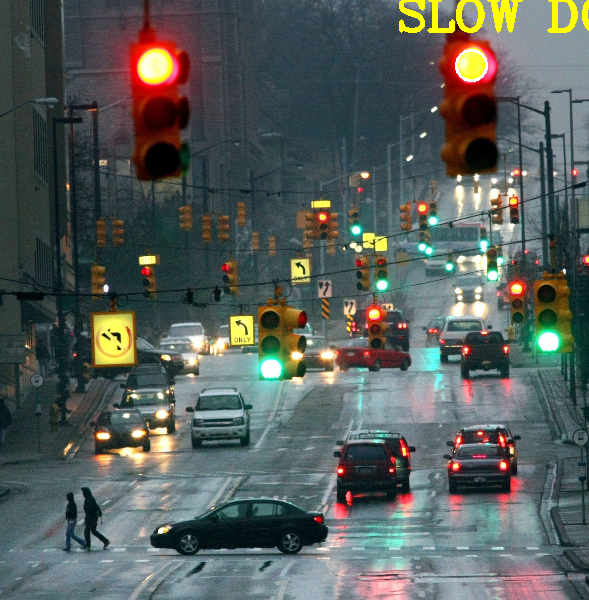

SLOW DOWN


In [ ]:
image = "https://www.mlive.com/resizer/v2/https%3A%2F%2Fadvancelocal-adapter-image-uploads.s3.amazonaws.com%2Fimage.mlive.com%2Fhome%2Fmlive-media%2Fwidth2048%2Fimg%2Fgrpress%2Fnews_impact%2Fphoto%2Ffulton-street-traffic-signals-synchronized-45d0b70ef344b19f.jpg?auth=fc02ec0355488e0f500fd6e72c4563987625e0a06172a7bee140177919b2f355&width=1280&quality=90"
classify_traffic_light(image)